In [2]:
import os
import pandas as pd
from datetime import datetime
import geopandas as gpd
import numpy as np

from shapely.geometry import mapping

import matplotlib.pyplot as plt
import contextily as cx

import rioxarray as rxr

from itertools import combinations
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import chi2



plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

## 1. Import and Clean Field Data

In [3]:
fielddata = pd.read_csv('../../data/field_data/LWC_LFM_WP_dates20230525.csv')

fielddata['mpa_mean'] = fielddata['mpa_mean'] * -1   # data was collected as positive values

def parse_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d')
    except:
        return None
    
fielddata['date'] = fielddata.apply(lambda row: parse_date(row['date_wp']), axis=1)

In [4]:
# functions to filter down to data relevant to the study period (i.e., within 8 days of image dates for predawn and within 4 days of image dates for midday)
img_date_list_str = ['20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
img_date_list = [datetime.strptime(datestr, '%Y%m%d') for datestr in img_date_list_str]
img_date_color_list = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#9B6981FF", "#7887A4FF", "#A89F8EFF"] # Arches

color_dict = dict(zip(img_date_list, img_date_color_list))

def check_date_pd(date):
    # check if date is within 8 days of any of the image dates
    for img_date in img_date_list:
        if abs((date - img_date).days) <= 8:
            return True
    return False

def check_date_md(date):
    # check if date is within 8 days of any of the image dates
    for img_date in img_date_list:
        if abs((date - img_date).days) <= 8:
            return True
    return False

In [5]:
# Separate and filter data by type and date

# Midday LWP data...
md_lwp = fielddata[['tree', 'time', 'species', 'mpa_mean', 'date']].copy().dropna()
md_lwp = md_lwp[md_lwp['time'] == 'md']
md_lwp = md_lwp[md_lwp['date'].apply(check_date_md)]
md_lwp = md_lwp.drop_duplicates()

# Midday LWC data...
md_lwc = fielddata[['tree', 'time', 'species', 'lwc_mean', 'date']].copy().dropna()
md_lwc = md_lwc[md_lwc['time'] == 'md']
md_lwc = md_lwc[md_lwc['date'].apply(check_date_md)]
md_lwc = md_lwc[md_lwc['lwc_mean'] < 1.4]   # indra says these very high values are most likely erroneous
md_lwc = md_lwc.drop_duplicates()

# Predawn LWP data...
pd_lwp = fielddata[['tree', 'time', 'species', 'mpa_mean', 'date']].copy().dropna()
pd_lwp = pd_lwp[pd_lwp['time'] == 'pd']
pd_lwp = pd_lwp[pd_lwp['date'].apply(check_date_pd)]
pd_lwp = pd_lwp.drop_duplicates()

In [6]:
# Append date of nearest flight
md_lwp['img_date'] = md_lwp['date'].apply(lambda x: min(img_date_list, key=lambda y: abs(x-y)))
md_lwc['img_date'] = md_lwc['date'].apply(lambda x: min(img_date_list, key=lambda y: abs(x-y)))
pd_lwp['img_date'] = pd_lwp['date'].apply(lambda x: min(img_date_list, key=lambda y: abs(x-y)))

In [7]:
# Link up data with lat/lon from the shapefile
tree_locs_file = '../../data/gis_data/all_trees.shp'
tree_locs = gpd.read_file(tree_locs_file)
tree_locs = tree_locs.to_crs(32610) # project to 32610 (UTM Zone 10N) for compatibility with the raster data

def get_lat_lon(tree_id):
    # check if the tree id is in the Comment field of the shapefile
    filtered_data = tree_locs[tree_locs['Comment'].str.contains(str(tree_id), na=False)]
    if len(filtered_data) > 1:
        print('Warning: multiple trees with the same ID found in the shapefile')
    if len(filtered_data) > 0:
        return filtered_data.iloc[0]['geometry'].y, filtered_data.iloc[0]['geometry'].x
    else:
        return None, None
    
md_lwp['lat'], md_lwp['lon'] = zip(*md_lwp['tree'].apply(get_lat_lon))
md_lwc['lat'], md_lwc['lon'] = zip(*md_lwc['tree'].apply(get_lat_lon))
pd_lwp['lat'], pd_lwp['lon'] = zip(*pd_lwp['tree'].apply(get_lat_lon))

## 2. Import and Link Environmental Data

In [8]:
topographic_data_dir = '../../data/topographic_data/'

# Load the topographic data
slope_path = os.path.join(topographic_data_dir, 'slope.tif')
aspect_path = os.path.join(topographic_data_dir, 'aspect.tif')
elevation_path = os.path.join(topographic_data_dir, 'output.dtm.tif')
twi_path = os.path.join(topographic_data_dir, 'twi_dinf_5m_avg.tif')

slope = rxr.open_rasterio(slope_path).squeeze().drop('band')
aspect = rxr.open_rasterio(aspect_path).squeeze().drop('band')
elevation = rxr.open_rasterio(elevation_path).squeeze().drop('band')
twi = rxr.open_rasterio(twi_path).squeeze().drop('band')

In [9]:
# get species from the lai_data spreadsheet
# what a horrible mess I've made with my tree_locs file...
lai_data = pd.read_csv('../../data/field_data/LAI_final.csv')

def get_species(treeid):
    treeid = str(treeid)
    lai_data_filtered = lai_data[lai_data['Treestr'].astype(str) == treeid]
    if len(lai_data_filtered) > 0:
        return lai_data_filtered.iloc[0]['Species']
    else:
        # check if just the first four characters match
        lai_data_filtered = lai_data[lai_data['Treestr'].apply(lambda x: str(x)[:4] == treeid)]
        if len(lai_data_filtered) > 0:
            return lai_data_filtered.iloc[0]['Species']
        # check if the last four characters match
        lai_data_filtered = lai_data[lai_data['Treestr'].apply(lambda x: str(x)[-4:] == treeid)]
        if len(lai_data_filtered) > 0:
            return lai_data_filtered.iloc[0]['Species']
    return None

tree_locs['species'] = tree_locs['Comment'].apply(get_species)

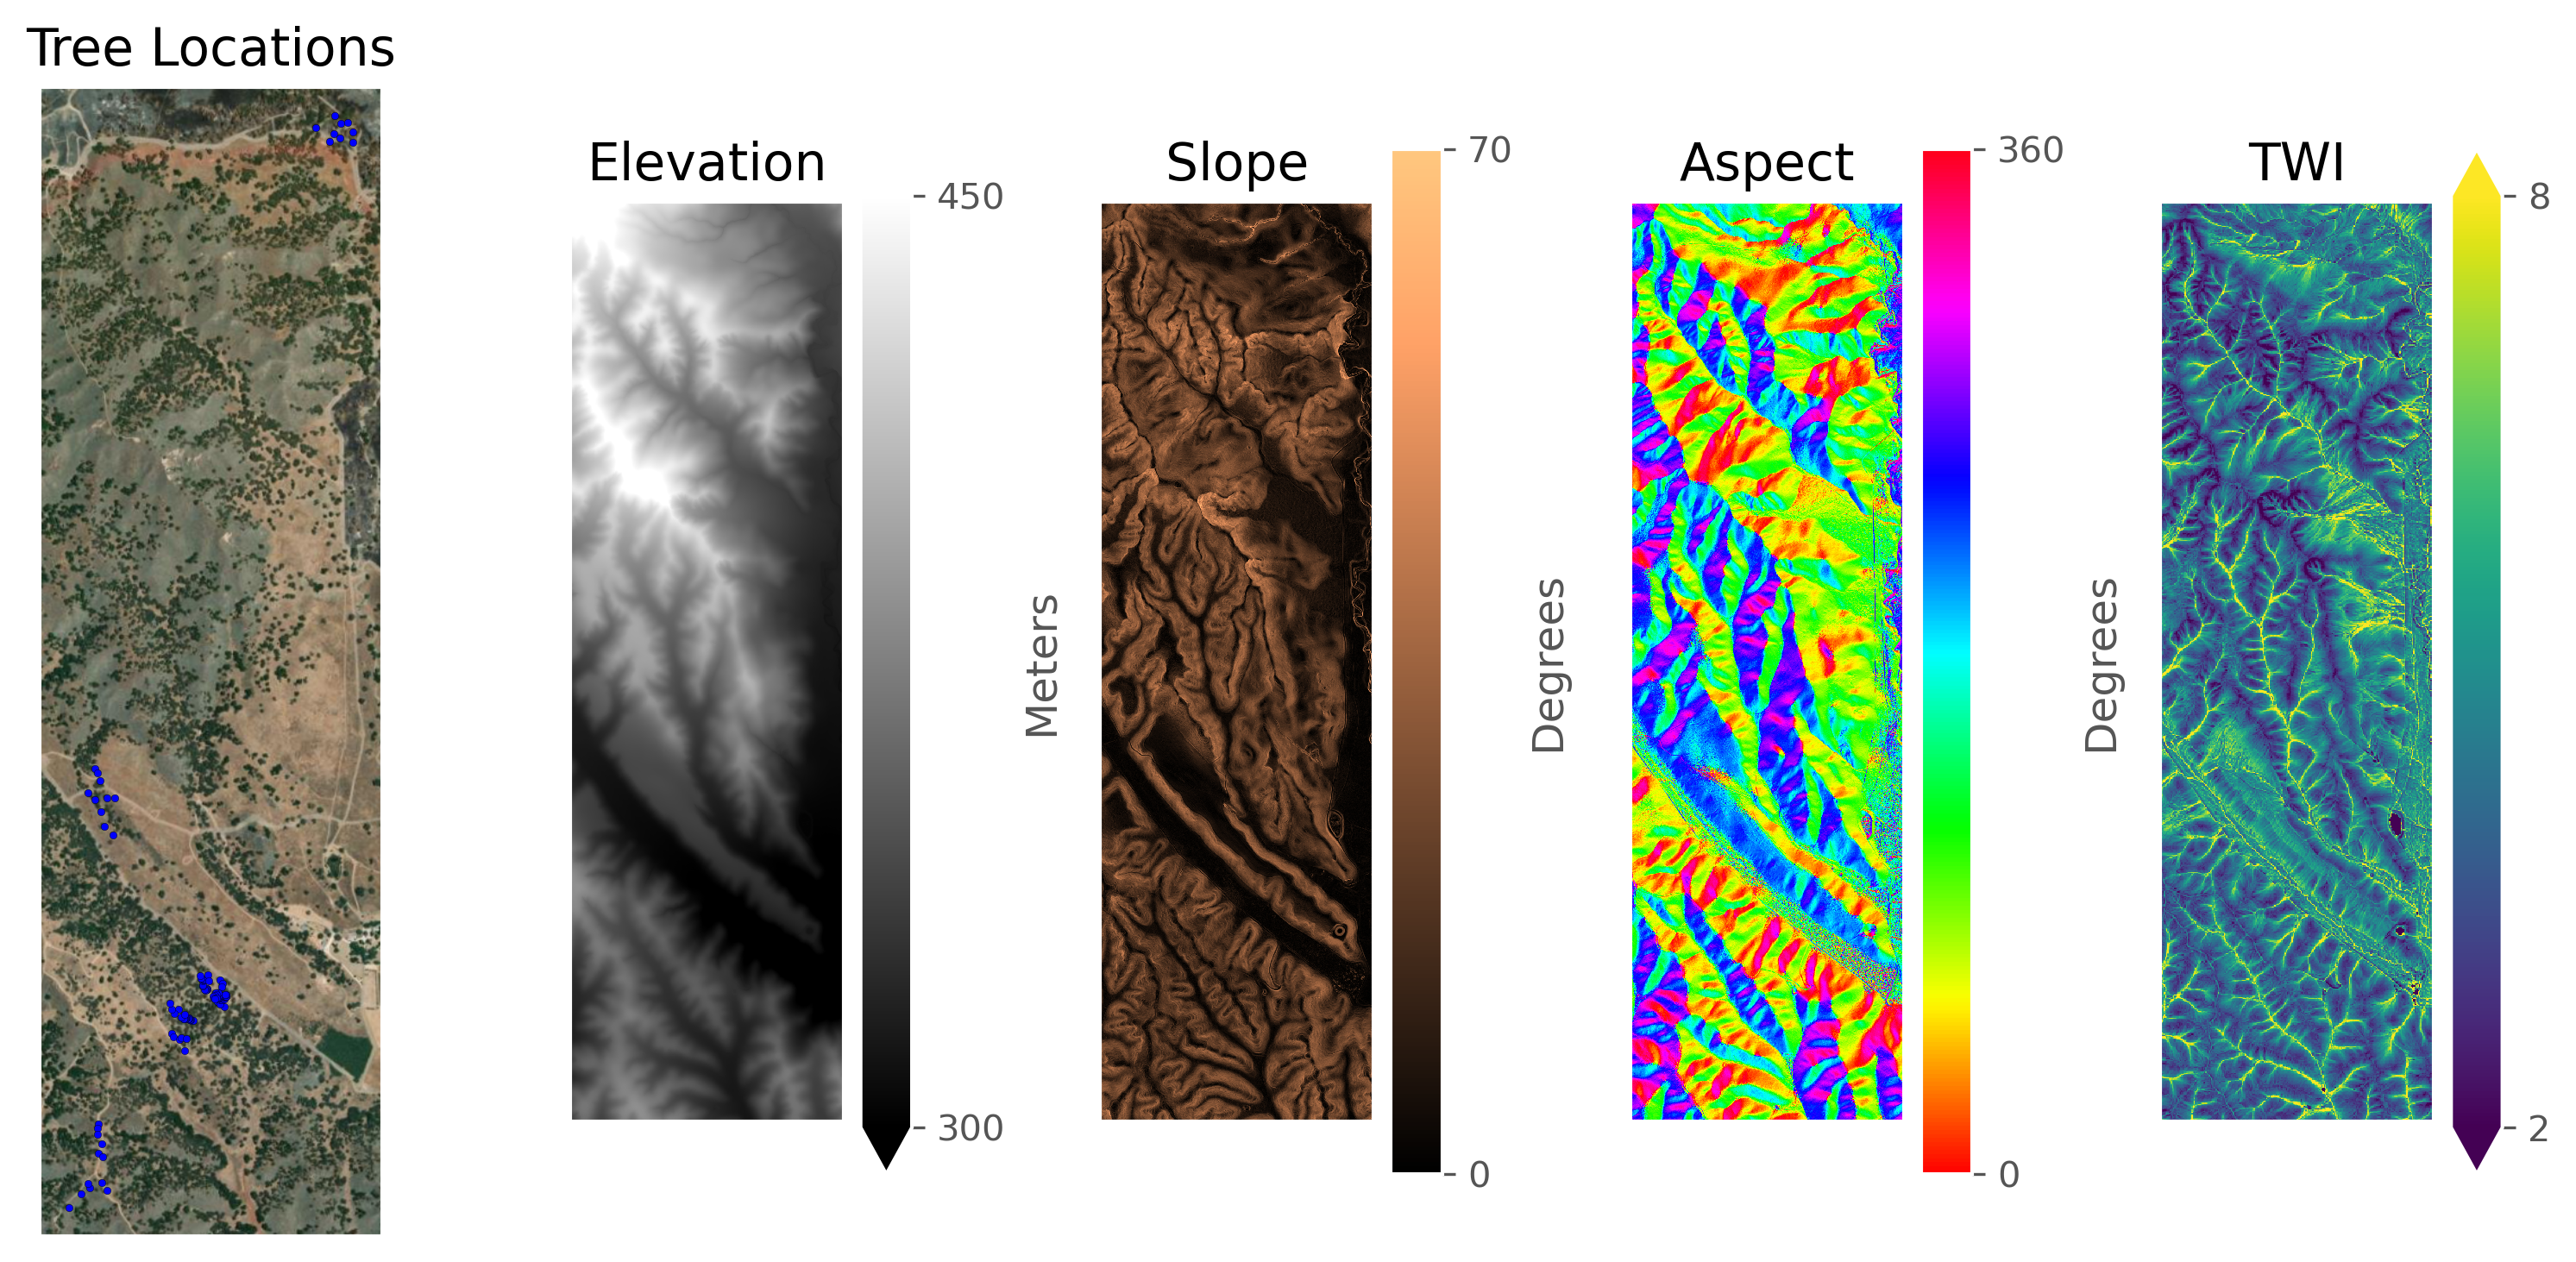

In [10]:
left_bound = pd_lwp['lon'].min()
right_bound = pd_lwp['lon'].max()
top_bound = pd_lwp['lat'].max()
bottom_bound = pd_lwp['lat'].min()

fig, axs = plt.subplots(1, 5, figsize=(10, 6))

# killing nans...
tree_locs['species'] = tree_locs['species'].fillna('unknown')

# plot tree locations on first subplot
tree_locs.plot(ax=axs[0], markersize=4, c='blue', edgecolor='black', linewidth=0.1)    
cx.add_basemap(axs[0], crs=tree_locs.crs, source=cx.providers.Esri.WorldImagery, attribution=False)
axs[0].set_title('Tree Locations')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_aspect('equal')
axs[0].set_xlim(left_bound-100, right_bound+100)
axs[0].set_ylim(bottom_bound-100, top_bound+100)


elevation.rio.clip_box(minx=left_bound-100, maxx=right_bound+100, miny=bottom_bound-100, maxy=top_bound+100).plot(ax=axs[1], cmap='gist_yarg_r', vmin=300, vmax=450)
axs[1].set_title('Elevation')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_aspect('equal')
# label colorbar
cbar = axs[1].collections[0].colorbar
cbar.set_label('Meters')
cbar.set_ticks([300, 450])
# tree_locs.plot(ax=axs[1], markersize=4, c=tree_locs['color'].tolist(), edgecolor='black', linewidth=0.1)    

slope.rio.clip_box(minx=left_bound-100, maxx=right_bound+100, miny=bottom_bound-100, maxy=top_bound+100).plot(ax=axs[2], cmap='copper', vmin=0, vmax=70)
axs[2].set_title('Slope')
axs[2].set_xlabel('')
axs[2].set_ylabel('')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_aspect('equal')
# label colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_label('Degrees')
cbar.set_ticks([0, 70])


aspect.rio.clip_box(minx=left_bound-100, maxx=right_bound+100, miny=bottom_bound-100, maxy=top_bound+100).plot(ax=axs[3], cmap='hsv', vmin=0, vmax=360)
axs[3].set_title('Aspect')
axs[3].set_xlabel('')
axs[3].set_ylabel('')
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_aspect('equal')
# label colorbar
cbar = axs[3].collections[0].colorbar
cbar.set_label('Degrees')
cbar.set_ticks([0, 360])


twi.rio.clip_box(minx=left_bound-100, maxx=right_bound+100, miny=bottom_bound-100, maxy=top_bound+100).plot(ax=axs[4], cmap='viridis', vmin=2, vmax=8)
axs[4].set_title('TWI')
axs[4].set_xlabel('')
axs[4].set_ylabel('')
axs[4].set_xticks([])
axs[4].set_yticks([])
axs[4].set_aspect('equal')
# label colorbar
cbar = axs[4].collections[0].colorbar
cbar.set_label('')
cbar.set_ticks([2, 8])


plt.tight_layout()
# plt.savefig('topographic_data.png')
plt.show()

In [11]:
# all should be 32610
slope_epsg = slope.rio.crs.to_epsg()
aspect_epsg = aspect.rio.crs.to_epsg()
elevation_epsg = elevation.rio.crs.to_epsg()
twi_epsg = twi.rio.crs.to_epsg()
tree_locs_epsg = tree_locs.crs.to_epsg()
assert slope_epsg == aspect_epsg == elevation_epsg == twi_epsg == tree_locs_epsg

In [12]:
# Extract topographic data for each tree
def get_topo_data(lat, lon):
    # get the index in the raster for the given lat/lon with handling for any nan values
    try:
        slope_val = slope.sel(x=lon, y=lat, method='nearest').values.item()
    except:
        slope_val = None
    try:
        aspect_val = aspect.sel(x=lon, y=lat, method='nearest').values.item()
    except:
        aspect_val = None
    try:
        elevation_val = elevation.sel(x=lon, y=lat, method='nearest').values.item()
    except:
        elevation_val = None
    try:
        twi_val = twi.sel(x=lon, y=lat, method='nearest').values.item()
    except:
        twi_val = None
    return slope_val, aspect_val, elevation_val, twi_val

md_lwp['slope'], md_lwp['aspect'], md_lwp['elevation'], md_lwp['twi'] = zip(*md_lwp.apply(lambda row: get_topo_data(row['lat'], row['lon']), axis=1))
md_lwc['slope'], md_lwc['aspect'], md_lwc['elevation'], md_lwc['twi'] = zip(*md_lwc.apply(lambda row: get_topo_data(row['lat'], row['lon']), axis=1))
pd_lwp['slope'], pd_lwp['aspect'], pd_lwp['elevation'], pd_lwp['twi'] = zip(*pd_lwp.apply(lambda row: get_topo_data(row['lat'], row['lon']), axis=1))

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version.

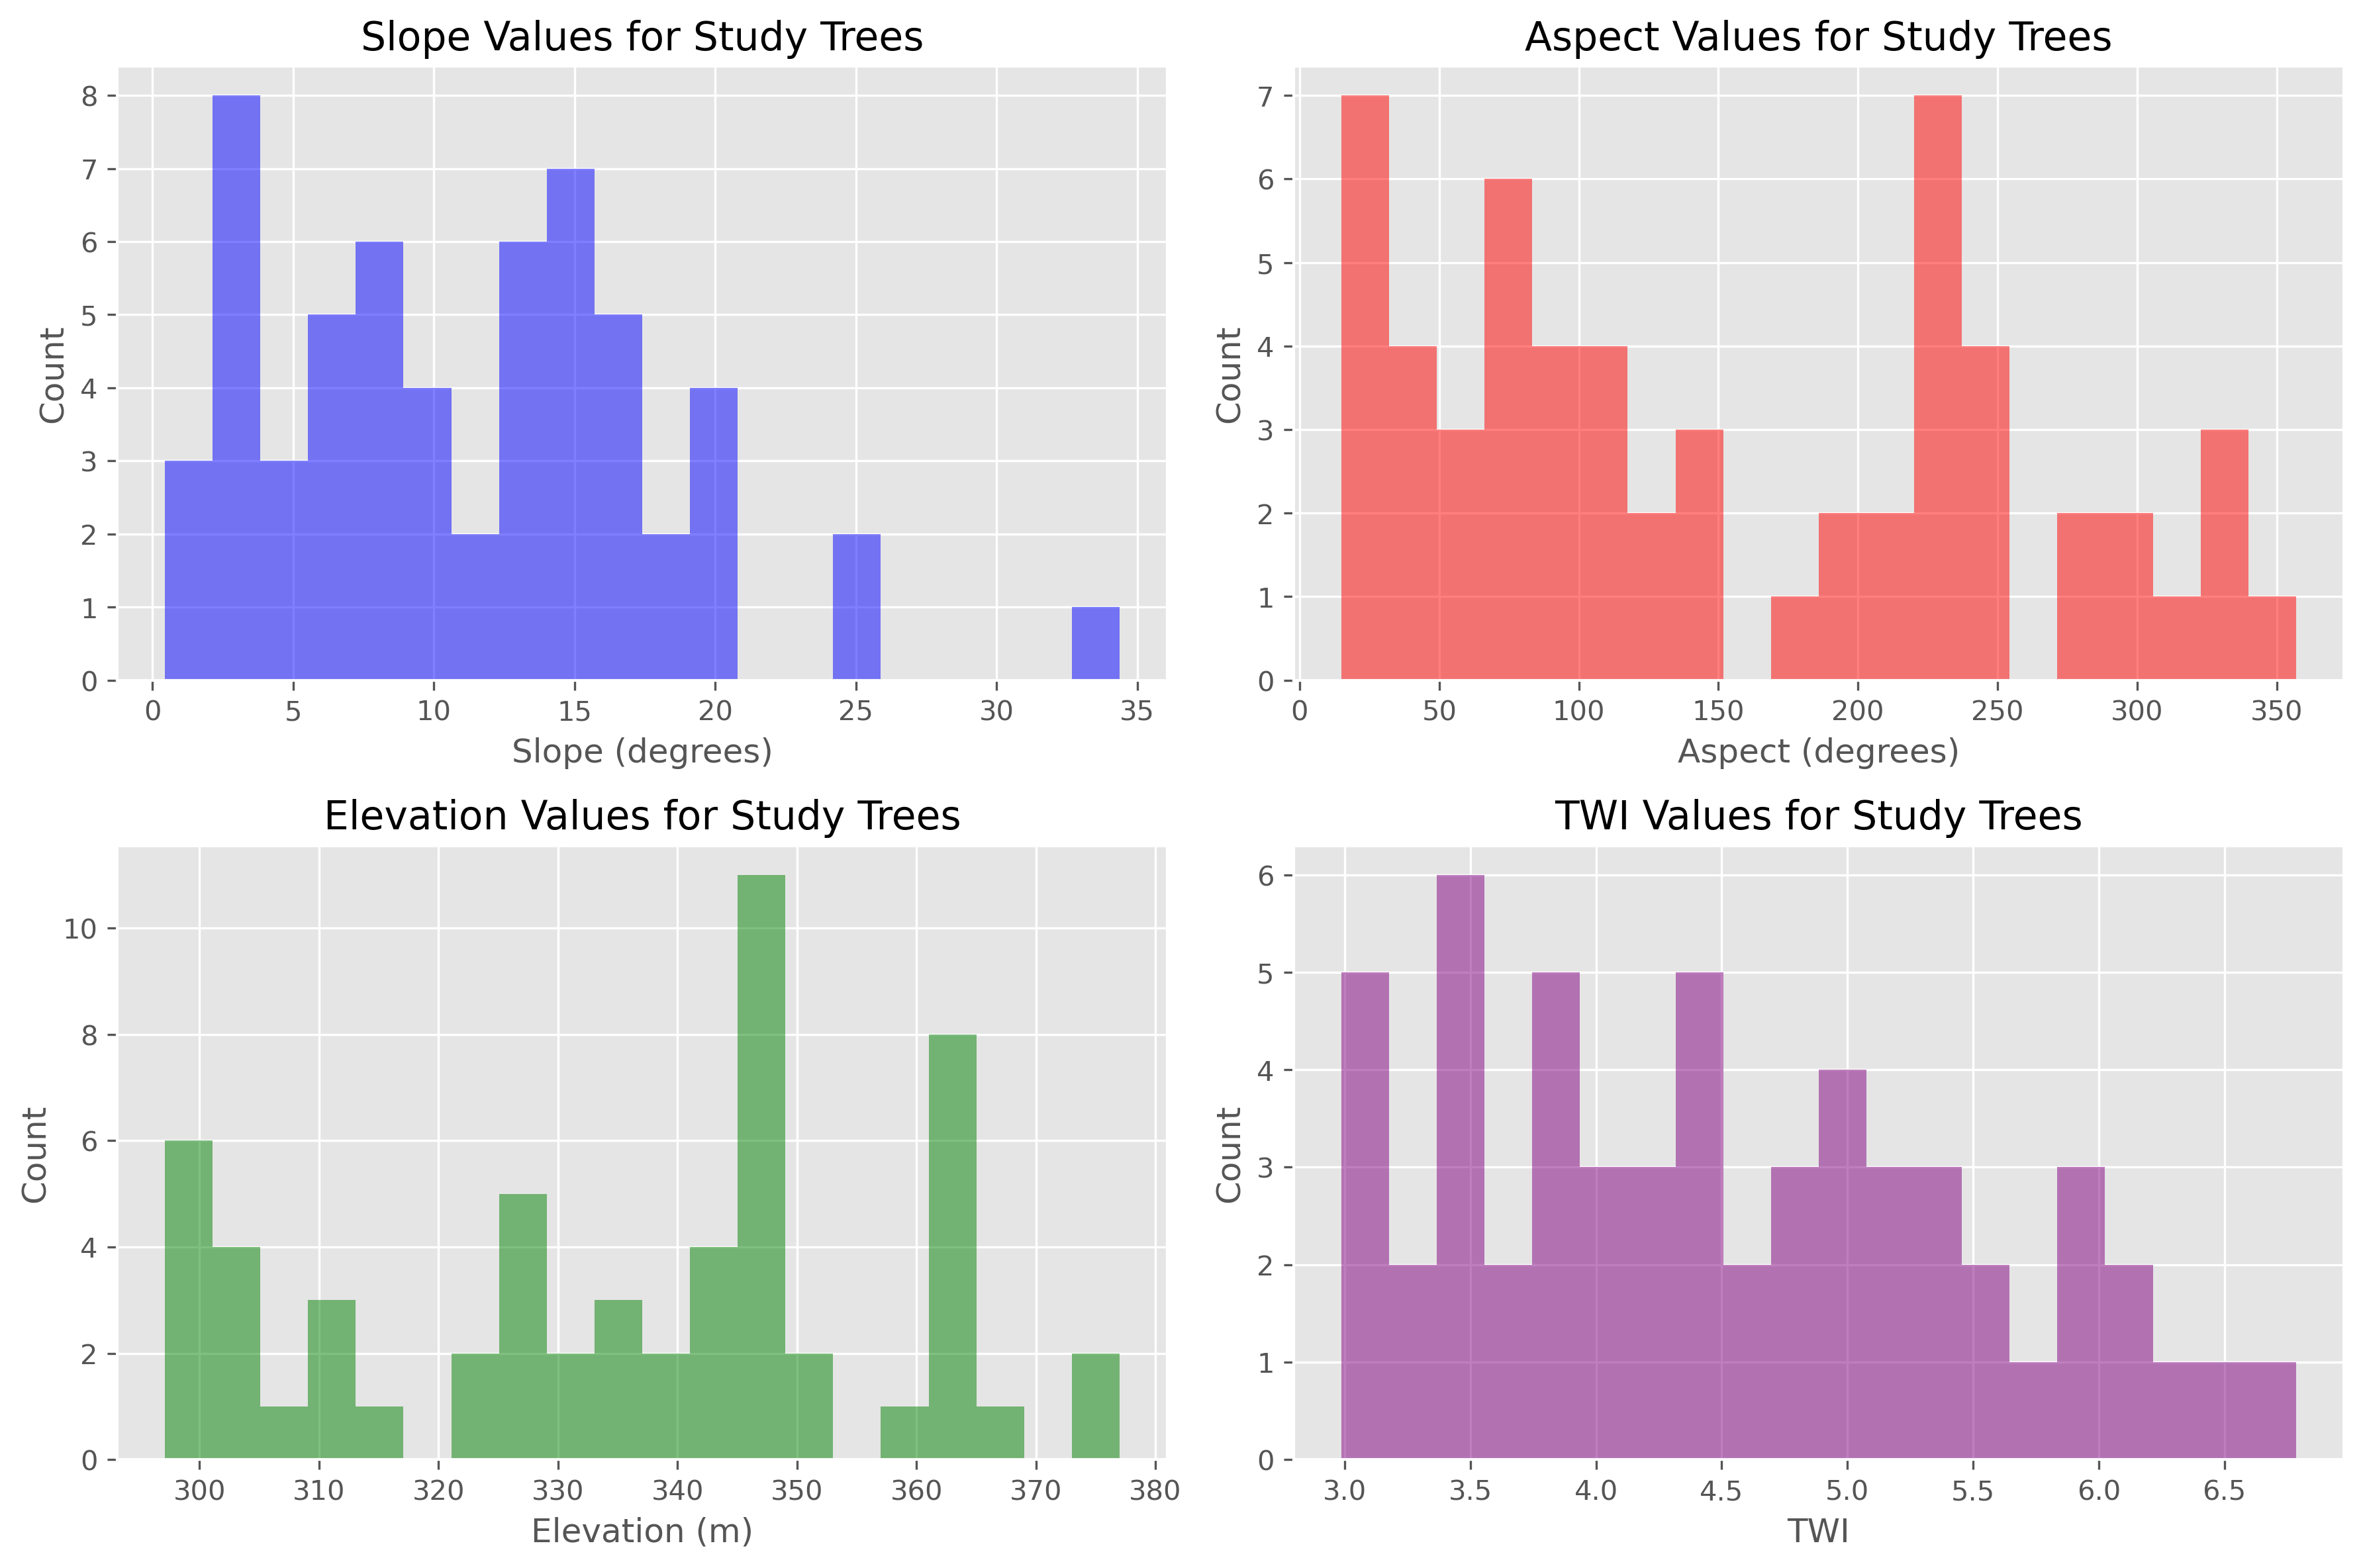

In [13]:
# histograms of the topographic data for the sampled trees
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

axs[0].hist(md_lwp['slope'].dropna().unique(), bins=20, color='blue', alpha=0.5)
axs[0].set_title('Slope Values for Study Trees')
axs[0].set_xlabel('Slope (degrees)')
axs[0].set_ylabel('Count')

axs[1].hist(md_lwp['aspect'].dropna().unique(), bins=20, color='red', alpha=0.5)
axs[1].set_title('Aspect Values for Study Trees')
axs[1].set_xlabel('Aspect (degrees)')
axs[1].set_ylabel('Count')

axs[2].hist(md_lwp['elevation'].dropna().unique(), bins=20, color='green', alpha=0.5)
axs[2].set_title('Elevation Values for Study Trees')
axs[2].set_xlabel('Elevation (m)')
axs[2].set_ylabel('Count')

axs[3].hist(md_lwp['twi'].dropna().unique(), bins=20, color='purple', alpha=0.5)
axs[3].set_title('TWI Values for Study Trees')
axs[3].set_xlabel('TWI')
axs[3].set_ylabel('Count')

plt.tight_layout()
# plt.savefig('topo_histograms.png')
plt.show()

## 3. Mapping Water Stress...

In [14]:
## subset just the Lisque site data -- then exporting to csv for use in ArcGIS Pro
lisque = tree_locs[ (tree_locs['Site'] == 'MiddleEarth')
                  | (tree_locs['Site'] == 'Ridge')
                  | (tree_locs['Site'] == 'Weathertop')
                  | (tree_locs['Site'] == 'Hobbiton')]

# go grab the september lwc data for img_date=2022-09-14 and join it to the lisque data
def get_sept_lwc(treeid):
    sept_datetime = pd.Timestamp('2022-09-14')
    treeid = str(treeid)
    lwc_data_filtered = fielddata[fielddata['tree'].astype(str) == treeid]
    lwc_data_filtered = lwc_data_filtered[lwc_data_filtered['time'] == 'md']
    # check for entries where date is within 4 days of the sept date
    lwc_data_filtered = lwc_data_filtered[lwc_data_filtered['date'].apply(lambda x: abs((x - sept_datetime).days) <= 4)]
    if len(lwc_data_filtered) > 0:
        return lwc_data_filtered.iloc[0]['lwc_mean']
    else:
        return None
    
lisque['sept_lwc'] = lisque['Comment'].apply(get_sept_lwc)

lisque['lat'] = lisque['geometry'].y
lisque['lon'] = lisque['geometry'].x

# lisque.to_csv('lisque_data.csv', index=False)

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


## 4. Mixed Effects Modeling

With help from https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

In [15]:
# start by adding CWC data to md_lwp, md_lwc, pd_lwp
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'
date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

In [16]:
# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.4998) & (df['CWC'] < 0.5) # dumb floating point bullsh*t
    df.loc[mask, 'CWC'] = np.nan
    return df

cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers, then sync up the rest of the data into one big dataframe
cwc = kill_nans(pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope'])).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    other_df = kill_nans(other_df)
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})

# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

In [17]:
# align CWC data with the field data
def get_cwc_data_md(tree_id, date):
    # check if there is a cwc date within 4 days of the field data date
    for this_date in datetime_list:
        if abs((this_date - date).days) <= 4:
            try:
                return cwc.loc[tree_id, 'CWC_' + this_date.strftime('%Y%m%d')]
            except:
                return None
    return None

def get_cwc_data_pd(tree_id, date):
    # check if there is a cwc date within 8 days of the field data date
    for this_date in datetime_list:
        if abs((this_date - date).days) <= 8:
            try:
                return cwc.loc[tree_id, 'CWC_' + this_date.strftime('%Y%m%d')]
            except:
                return None
    return None

md_lwc['cwc'] = md_lwc.apply(lambda row: get_cwc_data_md(row['tree'], row['date']), axis=1)
md_lwp['cwc'] = md_lwp.apply(lambda row: get_cwc_data_md(row['tree'], row['date']), axis=1)
pd_lwp['cwc'] = pd_lwp.apply(lambda row: get_cwc_data_pd(row['tree'], row['date']), axis=1)

In [18]:
# make sure we don't have any nan values anywhere
md_lwp = md_lwp.dropna()
md_lwc = md_lwc.dropna()
pd_lwp = pd_lwp.dropna()
md_lwp

tree time   species  mpa_mean       date   img_date           lat  \
2360  1478   md  blue oak -2.221000 2022-04-27 2022-04-29  3.843327e+06   
2375  2004   md  blue oak -2.620667 2022-04-27 2022-04-29  3.843454e+06   
2384  2005   md  blue oak -2.733000 2022-04-27 2022-04-29  3.843456e+06   
2399  2006   md  blue oak -2.717000 2022-04-27 2022-04-29  3.843515e+06   
2417  2007   md  blue oak -2.426333 2022-04-27 2022-04-29  3.843542e+06   
...    ...  ...       ...       ...        ...        ...           ...   
6448  2378   md  blue oak -4.317000 2022-09-15 2022-09-14  3.842706e+06   
6478  2379   md  blue oak -4.870667 2022-09-15 2022-09-14  3.842719e+06   
6484  2380   md  live oak -3.496000 2022-09-15 2022-09-14  3.842742e+06   
6504  2381   md  blue oak -4.740667 2022-09-15 2022-09-14  3.842616e+06   
6548  2383   md  blue oak -4.167667 2022-09-15 2022-09-14  3.842575e+06   

                lon      slope      aspect   elevation       twi       cwc  
2360  770220.519041   0.438390  222.535019  308.125885  5.197696  0.174713  
2375  770225.717503   5.929095  228.284668  340.702209  3.762231  0.145611  
2384  770197.575627  34.375816  251.173447  332.050171  6.039501  0.134170  
2399  770175.277448  24.752075  227.165314  333.156677  5.381670  0.173530  
2417  770165.969154   8.987707  186.696686  341.013031  5.175329  0.145473  
...             ...        ...         ...         ...       ...       ...  
6448  770431.487426  20.201580   88.184448  335.139252  4.839041  0.035850  
6478  770424.606562  14.368938  104.835625  336.725586  6.090522  0.037159  
6484  770416.533794  17.241861  125.408981  343.039124  3.674698  0.127105  
6504  770449.249694   1.635263   31.893391  347.732758  4.043537  0.080980  
6548  770468.979594   8.068461   23.597418  352.627747  3.026288  0.023650  

[187 rows x 13 columns]

In [28]:
# save all out to csv to do mixed modeling in r
md_lwp.to_csv('md_lwp.csv', index=False)
md_lwc.to_csv('md_lwc.csv', index=False)
pd_lwp.to_csv('pd_lwp.csv', index=False) 

In [22]:
# nested models for md_lwp
predictors = ['elevation', 'slope', 'aspect', 'cwc']

all_models_mdlwp = []

null_model = smf.mixedlm("mpa_mean ~ 1", md_lwp, groups=md_lwp["species_date"]).fit(reml=False, method="powell")
all_models_mdlwp.append(("mpa_mean ~ 1", null_model.converged, null_model.aic))

predicting = 'mpa_mean'
for r in range(1, len(predictors) + 1):
    for combo in combinations(predictors, r):
        formula = " ~ " + " + ".join(combo)
        model = smf.mixedlm(predicting + formula, md_lwp, groups=md_lwp["img_date"], re_formula=formula).fit(reml=False, method="powell")
        all_models_mdlwp.append((predicting + formula, model.converged, model.aic))

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

In [23]:
md_lwp_models_df = pd.DataFrame(all_models_mdlwp, columns=['formula', 'converged', 'aic'])
md_lwp_models_df = md_lwp_models_df.sort_values('aic')
# md_lwp_models_df.to_csv('md_lwp_models.csv', index=False)
md_lwp_models_df

formula  converged         aic
4                                mpa_mean ~ cwc       True  282.022020
9                        mpa_mean ~ slope + cwc       True  282.173413
7                    mpa_mean ~ elevation + cwc       True  285.044006
12           mpa_mean ~ elevation + slope + cwc       True  286.488299
10                      mpa_mean ~ aspect + cwc       True  289.965475
14              mpa_mean ~ slope + aspect + cwc       True  292.026480
0                                  mpa_mean ~ 1       True  293.925611
13          mpa_mean ~ elevation + aspect + cwc       True  296.132372
1                          mpa_mean ~ elevation       True  296.936564
15  mpa_mean ~ elevation + slope + aspect + cwc       True  298.385627
5                  mpa_mean ~ elevation + slope       True  298.604932
2                              mpa_mean ~ slope       True  299.606376
6                 mpa_mean ~ elevation + aspect       True  304.446822
3                             mpa_mean ~ aspect       True  306.298379
8                     mpa_mean ~ slope + aspect       True  306.322182
11        mpa_mean ~ elevation + slope + aspect       True  310.078910

In [24]:
# nested models for md_lwc
predictors = ['elevation', 'slope', 'aspect', 'twi', 'cwc']

all_models_mdlwc = []

null_model = smf.mixedlm("lwc_mean ~ 1", md_lwc, groups=md_lwc["species_date"]).fit(reml=False, method="powell")
all_models_mdlwc.append(("lwc_mean ~ 1", null_model.converged, null_model.aic))

predicting = 'lwc_mean'
for r in range(1, len(predictors) + 1):
    for combo in combinations(predictors, r):
        formula = " ~ " + " + ".join(combo)
        model = smf.mixedlm(predicting + formula, md_lwc, groups=md_lwc["img_date"], re_formula=formula).fit(reml=False, method="powell")
        all_models_mdlwc.append((predicting + formula, model.converged, model.aic))

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

In [25]:
md_lwc_models_df = pd.DataFrame(all_models_mdlwc, columns=['formula', 'converged', 'aic'])
md_lwc_models_df = md_lwc_models_df.sort_values('aic')
# md_lwc_models_df.to_csv('md_lwc_models.csv', index=False)
md_lwc_models_df

formula  converged         aic
0                                        lwc_mean ~ 1       True -443.594729
2                                    lwc_mean ~ slope       True -379.172732
12                             lwc_mean ~ slope + cwc       True -377.240560
11                             lwc_mean ~ slope + twi       True -372.046680
10                          lwc_mean ~ slope + aspect       True -371.832494
6                        lwc_mean ~ elevation + slope       True -369.440394
24                       lwc_mean ~ slope + twi + cwc       True -368.366628
18                 lwc_mean ~ elevation + slope + cwc       True -362.620423
22                    lwc_mean ~ slope + aspect + twi       True -362.539627
17                 lwc_mean ~ elevation + slope + twi       True -360.641041
23                    lwc_mean ~ slope + aspect + cwc       True -358.017558
27        lwc_mean ~ elevation + slope + aspect + cwc       True -357.632942
16              lwc_mean ~ elevation + slope + aspect       True -356.828117
5                                      lwc_mean ~ cwc       True -355.914094
28           lwc_mean ~ elevation + slope + twi + cwc       True -352.748975
3                                   lwc_mean ~ aspect       True -352.531218
1                                lwc_mean ~ elevation       True -352.480452
4                                      lwc_mean ~ twi       True -352.403249
26        lwc_mean ~ elevation + slope + aspect + twi       True -350.374561
30              lwc_mean ~ slope + aspect + twi + cwc       True -349.071960
14                            lwc_mean ~ aspect + cwc       True -348.986682
9                          lwc_mean ~ elevation + cwc       True -348.715449
15                               lwc_mean ~ twi + cwc       True -348.261261
8                          lwc_mean ~ elevation + twi       True -345.368522
31  lwc_mean ~ elevation + slope + aspect + twi + cwc       True -344.805178
7                       lwc_mean ~ elevation + aspect       True -344.724288
13                            lwc_mean ~ aspect + twi       True -344.679354
20                lwc_mean ~ elevation + aspect + cwc       True -339.794690
25                      lwc_mean ~ aspect + twi + cwc       True -339.363206
21                   lwc_mean ~ elevation + twi + cwc       True -336.815926
19                lwc_mean ~ elevation + aspect + twi       True -335.400548
29          lwc_mean ~ elevation + aspect + twi + cwc       True -324.752918

In [26]:
# nested models for pd_lwp
predictors = ['elevation', 'slope', 'aspect', 'twi', 'cwc']

all_models_pdlwp = []

null_model = smf.mixedlm("mpa_mean ~ 1", pd_lwp, groups=pd_lwp["species_date"]).fit(reml=False, method="powell")
all_models_pdlwp.append(("mpa_mean ~ 1", null_model.converged, null_model.aic))

predicting = 'mpa_mean'
for r in range(1, len(predictors) + 1):
    for combo in combinations(predictors, r):
        formula = " ~ " + " + ".join(combo)
        model = smf.mixedlm(predicting + formula, pd_lwp, groups=pd_lwp["img_date"], re_formula=formula).fit(reml=False, method="powell")
        all_models_pdlwp.append((predicting + formula, model.converged, model.aic))

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

In [27]:
pd_lwp_models_df = pd.DataFrame(all_models_pdlwp, columns=['formula', 'converged', 'aic'])
pd_lwp_models_df = pd_lwp_models_df.sort_values('aic')
# pd_lwp_models_df.to_csv('pd_lwp_models.csv', index=False)
pd_lwp_models_df

formula  converged         aic
0                                        mpa_mean ~ 1       True  207.190596
5                                      mpa_mean ~ cwc       True  234.522152
14                            mpa_mean ~ aspect + cwc       True  238.805874
15                               mpa_mean ~ twi + cwc       True  238.850001
9                          mpa_mean ~ elevation + cwc       True  240.359638
12                             mpa_mean ~ slope + cwc       True  242.016185
25                      mpa_mean ~ aspect + twi + cwc       True  244.970910
24                       mpa_mean ~ slope + twi + cwc       True  248.627254
23                    mpa_mean ~ slope + aspect + cwc       True  248.739729
18                 mpa_mean ~ elevation + slope + cwc       True  249.794293
21                   mpa_mean ~ elevation + twi + cwc       True  257.910860
27        mpa_mean ~ elevation + slope + aspect + cwc       True  259.213083
20                mpa_mean ~ elevation + aspect + cwc       True  259.351001
30              mpa_mean ~ slope + aspect + twi + cwc       True  260.624860
3                                   mpa_mean ~ aspect       True  265.291386
28           mpa_mean ~ elevation + slope + twi + cwc       True  267.463741
1                                mpa_mean ~ elevation       True  268.904170
7                       mpa_mean ~ elevation + aspect       True  269.381052
31  mpa_mean ~ elevation + slope + aspect + twi + cwc       True  270.139895
4                                      mpa_mean ~ twi       True  270.935207
29          mpa_mean ~ elevation + aspect + twi + cwc       True  271.509503
10                          mpa_mean ~ slope + aspect       True  272.055939
2                                    mpa_mean ~ slope       True  272.934612
13                            mpa_mean ~ aspect + twi       True  276.015727
6                        mpa_mean ~ elevation + slope       True  276.426416
11                             mpa_mean ~ slope + twi       True  277.353323
8                          mpa_mean ~ elevation + twi       True  280.370184
17                 mpa_mean ~ elevation + slope + twi       True  280.390146
22                    mpa_mean ~ slope + aspect + twi       True  281.132097
19                mpa_mean ~ elevation + aspect + twi       True  283.322128
26        mpa_mean ~ elevation + slope + aspect + twi       True  286.361968
16              mpa_mean ~ elevation + slope + aspect       True  286.618161

## 5. Variance Explained

In [31]:
# function to calculate marginal r2 values
def calc_r2(predicting, formula, df):
    model = smf.mixedlm(predicting + formula, df, groups=df["img_date"], re_formula=formula).fit(reml=False, method="powell")
    print(model.aic)

    # Variance Components
    var_fixed = np.var(model.fittedvalues)  # Variance explained by fixed effects
    var_random = sum(model.cov_re.iloc[0])  # Variance due to random effects
    var_residual = model.scale  # Residual variance

    # Compute R² values
    marginal_r2 = var_fixed / (var_fixed + var_random + var_residual)  # Fixed effects only
    conditional_r2 = (var_fixed + var_random) / (var_fixed + var_random + var_residual)  # Fixed + random

    return marginal_r2, conditional_r2

In [33]:
calc_r2('lwc_mean', " ~ cwc", md_lwc)

-355.914094169005


c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(0.640232222603546, 0.5221031895762732)

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

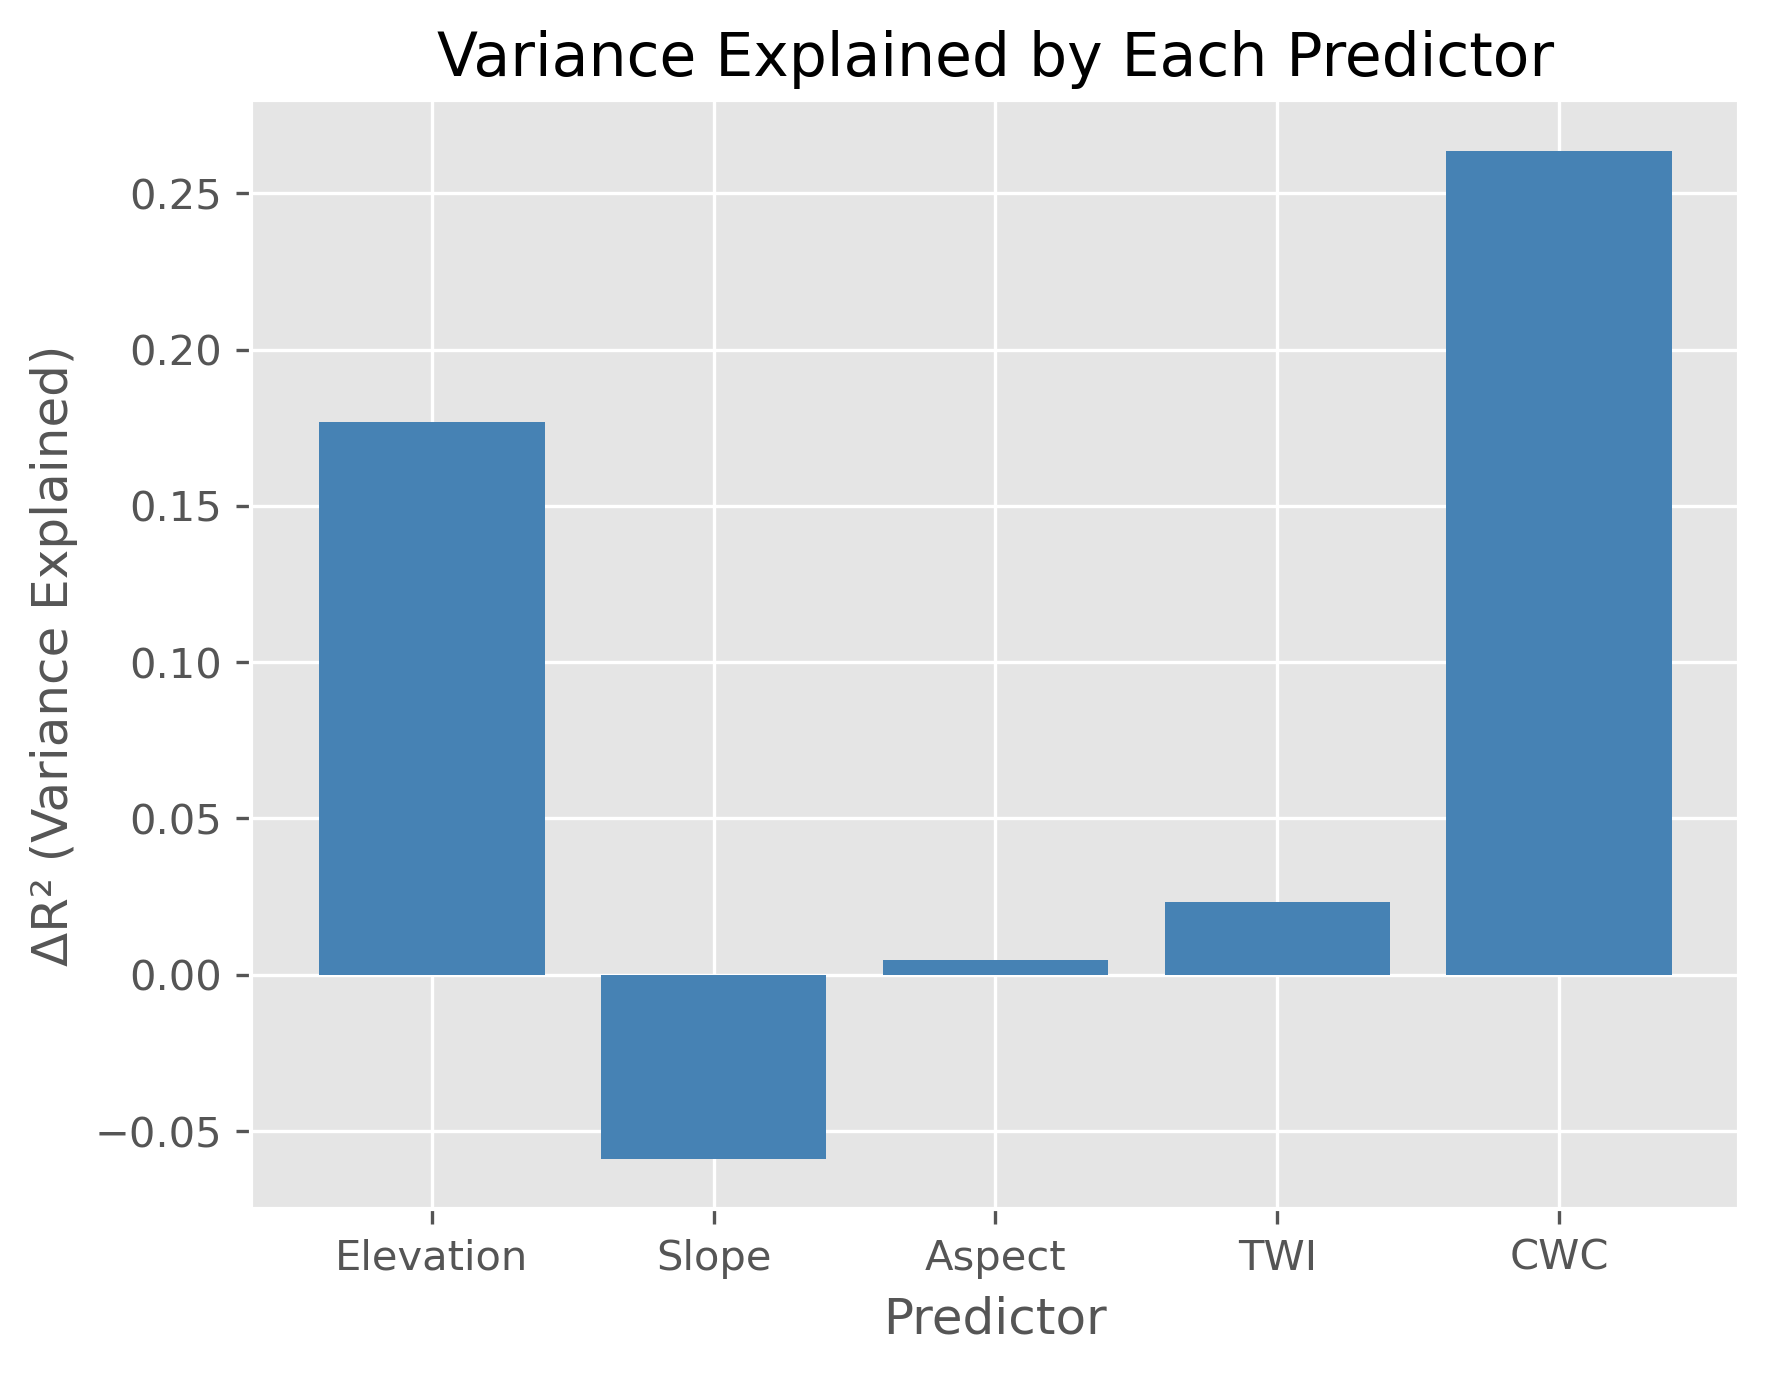

In [26]:
# Leaf Water Content...
r2_null, _ = calc_r2('lwc_mean', " ~ 1", md_lwc)
r2_elevation, _ = calc_r2('lwc_mean', " ~ elevation", md_lwc)
r2_slope, _ = calc_r2('lwc_mean', " ~ slope", md_lwc)
r2_aspect, _ = calc_r2('lwc_mean', " ~ aspect", md_lwc)
r2_twi, _ = calc_r2('lwc_mean', " ~ twi", md_lwc)
r2_cwc, _ = calc_r2('lwc_mean', " ~ cwc", md_lwc)

variance_explained = {
    "Elevation": r2_elevation - r2_null,
    "Slope": r2_slope - r2_null,
    "Aspect": r2_aspect - r2_null,
    "TWI": r2_twi - r2_null,
    "CWC": r2_cwc - r2_null
}

var_df = pd.DataFrame(variance_explained.items(), columns=["Predictor", "Variance Explained"])

plt.bar(var_df["Predictor"], var_df["Variance Explained"], color="steelblue")
plt.xlabel("Predictor")
plt.ylabel("ΔR² (Variance Explained)")
plt.title("Variance Explained by Each Predictor")
plt.show()

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

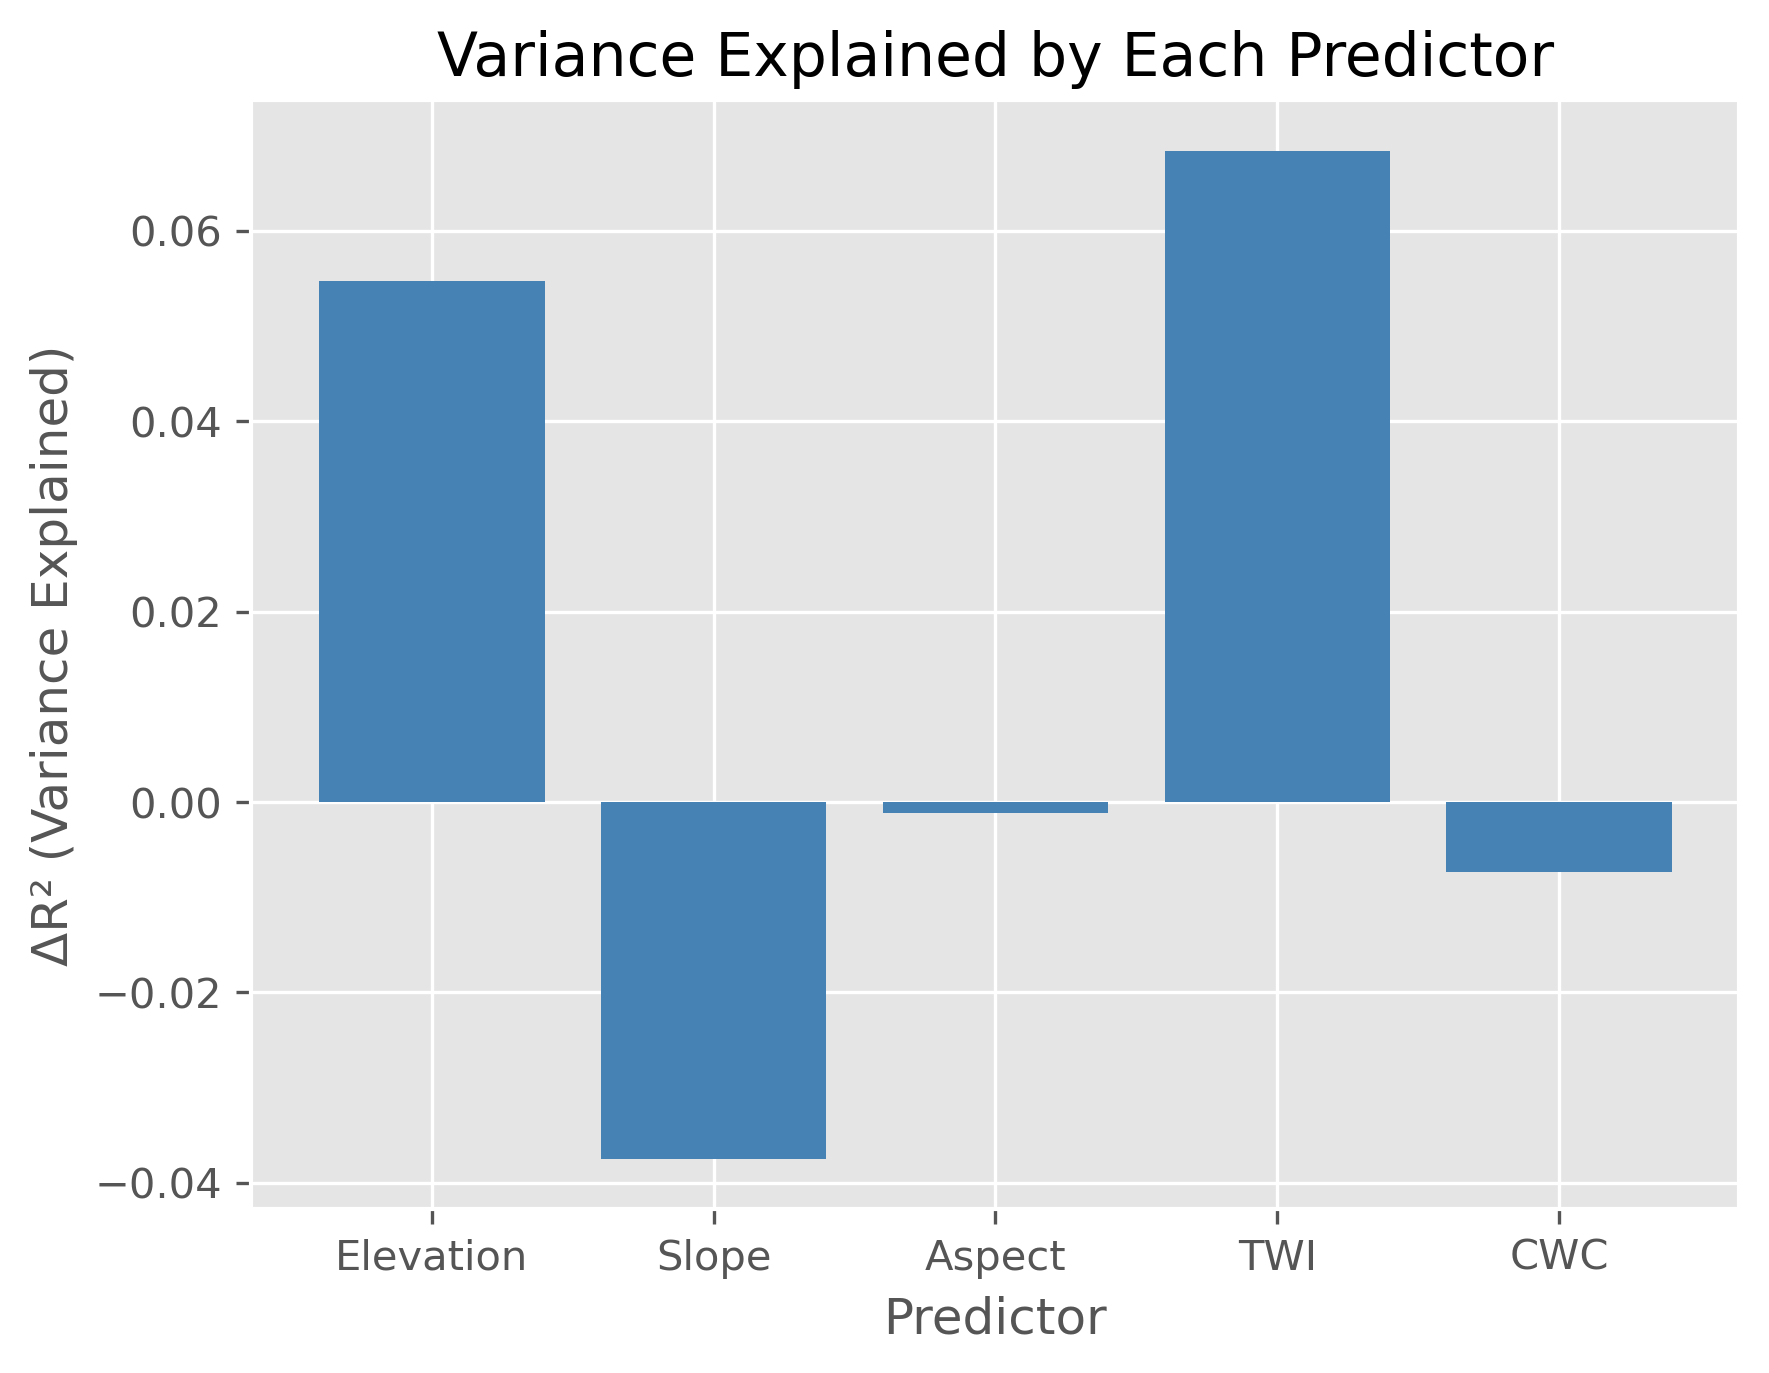

In [27]:
# Midday LWP...
r2_null, _ = calc_r2('mpa_mean', " ~ 1", md_lwp)
r2_elevation, _ = calc_r2('mpa_mean', " ~ elevation", md_lwp)
r2_slope, _ = calc_r2('mpa_mean', " ~ slope", md_lwp)
r2_aspect, _ = calc_r2('mpa_mean', " ~ aspect", md_lwp)
r2_twi, _ = calc_r2('mpa_mean', " ~ twi", md_lwp)
r2_cwc, _ = calc_r2('mpa_mean', " ~ cwc", md_lwp)

variance_explained = {
    "Elevation": r2_elevation - r2_null,
    "Slope": r2_slope - r2_null,
    "Aspect": r2_aspect - r2_null,
    "TWI": r2_twi - r2_null,
    "CWC": r2_cwc - r2_null
}

var_df = pd.DataFrame(variance_explained.items(), columns=["Predictor", "Variance Explained"])

plt.bar(var_df["Predictor"], var_df["Variance Explained"], color="steelblue")
plt.xlabel("Predictor")
plt.ylabel("ΔR² (Variance Explained)")
plt.title("Variance Explained by Each Predictor")
plt.show()


c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

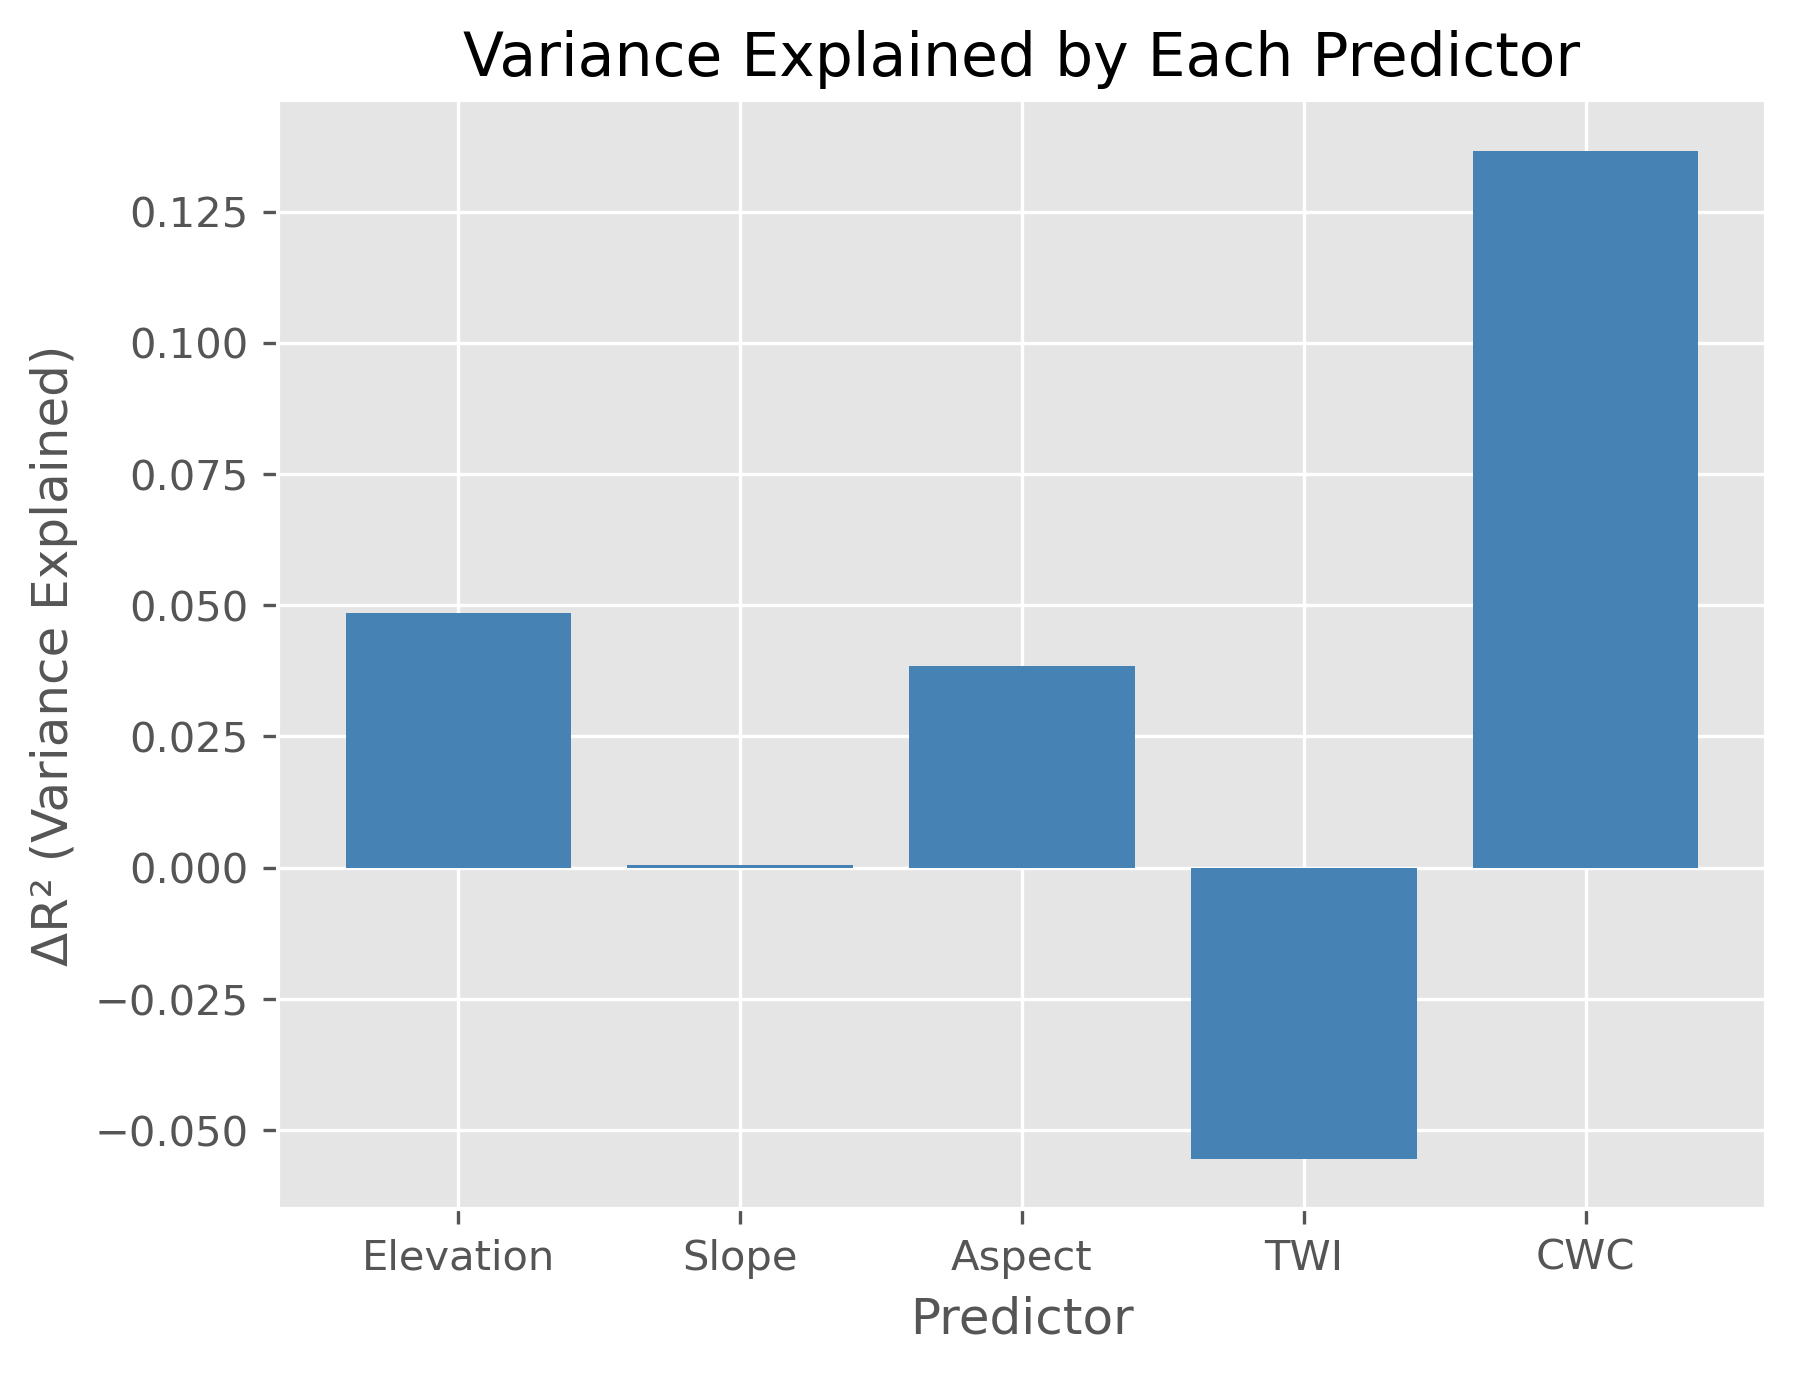

In [28]:
# Predawn LWP...
r2_null, _ = calc_r2('mpa_mean', " ~ 1", pd_lwp)
r2_elevation, _ = calc_r2('mpa_mean', " ~ elevation", pd_lwp)
r2_slope, _ = calc_r2('mpa_mean', " ~ slope", pd_lwp)
r2_aspect, _ = calc_r2('mpa_mean', " ~ aspect", pd_lwp)
r2_twi, _ = calc_r2('mpa_mean', " ~ twi", pd_lwp)
r2_cwc, _ = calc_r2('mpa_mean', " ~ cwc", pd_lwp)

variance_explained = {
    "Elevation": r2_elevation - r2_null,
    "Slope": r2_slope - r2_null,
    "Aspect": r2_aspect - r2_null,
    "TWI": r2_twi - r2_null,
    "CWC": r2_cwc - r2_null
}

var_df = pd.DataFrame(variance_explained.items(), columns=["Predictor", "Variance Explained"])

plt.bar(var_df["Predictor"], var_df["Variance Explained"], color="steelblue")
plt.xlabel("Predictor")
plt.ylabel("ΔR² (Variance Explained)")
plt.title("Variance Explained by Each Predictor")
plt.show()

In [29]:
# nested models for md_lwc
predictors = ['elevation', 'slope', 'aspect', 'twi', 'cwc']

all_models_mdlwc = []

null_model = smf.mixedlm("lwc_mean ~ 1", md_lwc, groups=md_lwc["img_date"]).fit(reml=False, method="powell")
all_models_mdlwc.append(("lwc_mean ~ 1", null_model.converged, null_model.aic))

predicting = 'lwc_mean'
for r in range(1, len(predictors) + 1):
    for combo in combinations(predictors, r):
        formula = " ~ " + " + ".join(combo)
        model = smf.mixedlm(predicting + formula, md_lwc, groups=md_lwc["img_date"], re_formula=formula).fit(reml=False, method="powell")
        all_models_mdlwc.append((predicting + formula, model))

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\statsmodels\regression\mixed

In [30]:
# regression between slope and lwc form md_lwc
model = smf.ols("lwc_mean ~ slope", md_lwc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lwc_mean   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     5.453
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0207
Time:                        07:46:47   Log-Likelihood:                 119.65
No. Observations:                 179   AIC:                            -235.3
Df Residuals:                     177   BIC:                            -228.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7806      0.018     44.065      0.000       0.746       0.816
slope         -0.0030      0.001     -2.335      0.021      -0.006      -0.000
==============================================================================
Omnibus:                       21.787   Durbin-Watson:                   0.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.019
Skew:                          -0.147   Prob(JB):                       0.0299
Kurtosis:                       2.076   Cond. No.                         26.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""